<a href="https://colab.research.google.com/github/nataliawcislo/Prediction-Stock-Prices/blob/main/Copy_of_regresion_prediction_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read in data

In [1]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  print(len(fn))

Saving wig20_d.csv to wig20_d.csv
User uploaded file "wig20_d.csv" with length 296058 bytes
11


In [3]:
import pandas as pd

#Read in data
dataset = pd.read_csv(fn, header = 0)
print('the total numbers of rows from a CSV file: ' + str(len(dataset)))

#Drop Nan columns
dataset = dataset.dropna()
print(dataset.head)
print(dataset.dtypes)
print('Before: ' + str(len(dataset)))

# convert , to normal number


the total numbers of rows from a CSV file: 7239
<bound method NDFrame.head of            Data     Open     High      Low    Close
0     4/16/1991   100.00   100.00   100.00   100.00
1     4/23/1991    95.70    95.70    95.70    95.70
2     4/30/1991    93.50    93.50    93.50    93.50
3     5/14/1991    92.90    92.90    92.90    92.90
4     5/21/1991    95.50    95.50    95.50    95.50
...         ...      ...      ...      ...      ...
7234   1/7/2022  2309.61  2314.16  2278.63  2311.93
7235  1/10/2022  2311.34  2328.41  2289.59  2291.23
7236  1/11/2022  2300.38  2345.44  2296.03  2344.45
7237  1/12/2022  2350.99  2411.11  2350.99  2411.11
7238  1/13/2022  2406.83  2429.03  2397.64  2407.62

[7239 rows x 5 columns]>
Data      object
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
Before: 7239


Clean file

In [30]:
# import pandas as pd

# dataset = dataset.replace(",", "", regex=True)
# dataset = dataset.rename(columns = {'Data': 'Date'} )
# # check format
# print(dataset.dtypes)
# # Change formay
# dataset["Date"]= pd.to_datetime(dataset["Date"])
# dataset['High'] = dataset['High'].astype('float32')
# dataset['Open'] = dataset['Open'].astype('float32')
# dataset['Low'] = dataset['Low'].astype('float32')
# dataset['Close'] = dataset['Close'].astype('float32')
# dataset['Volume'] = dataset['Volume'].astype('float32')
# # check format
# print(dataset.dtypes)
# # sort old -> young
# # dataset.sort_values(by='Date', inplace=True)
# # Double check the result
# dataset.head()
# print(dataset) 

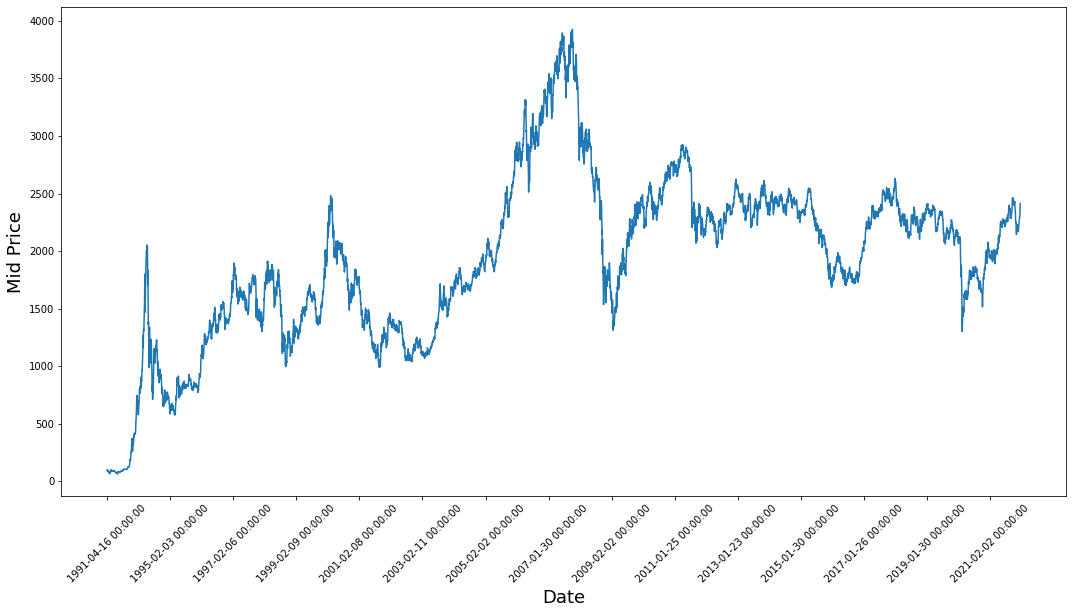

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(range(dataset.shape[0]),(dataset['Low'] + dataset['High'])/2.0)
plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Dimension of train data:  (5067, 5)
Dimension of test data:  (2172, 5)


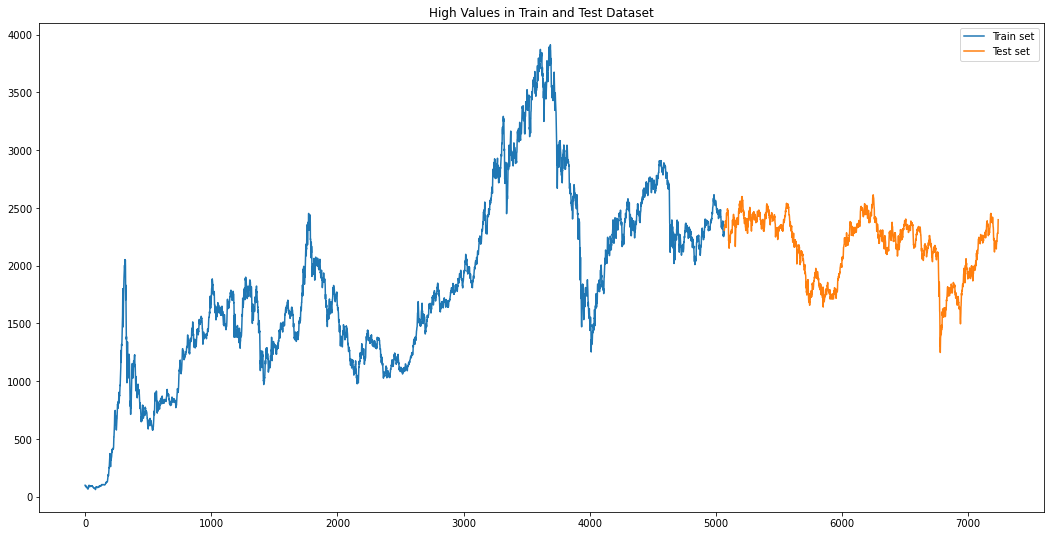

In [6]:
train_size = int(len(dataset)*0.7)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

# Plot train and test data
plt.figure(figsize = (18,9))
plt.plot(train_dataset.Low, label = "Train")
plt.plot(test_dataset.Low, label = "Test")
# plt.xlabel('Time (day)')
# plt.ylabel('Daily water consumption ($m^3$/capita.day)')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)
plt.title('High Values in Train and Test Dataset')
plt.show()

In [7]:
# Split train data to X and y
X_train = train_dataset.drop(['Close','Date'], axis = 1)
print(X_train.shape)
y_train = train_dataset.loc[:,['Close']].to_numpy()
print(y_train.shape)
# Split test data to X and y
X_test = test_dataset.drop(['Close','Date'], axis = 1)
print(X_test.shape)
y_test = test_dataset.loc[:,['Close']].to_numpy()
print(y_test.shape)

train_size = int(len(X_test)*0.9)
x_dataset = X_test.iloc[train_size:]
print(x_dataset.shape)
print(train_size)
y_train_size = int(len(y_test)*0.9)
y_dataset = test_dataset.loc[:,['Close']].iloc[y_train_size:]

print(y_dataset.shape)


(5067, 3)
(5067, 1)
(2172, 3)
(2172, 1)
(218, 3)
1954
(218, 1)


In [8]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [9]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (2142, 30, 3)
y_train.shape:  (5037, 1)
X_test.shape:  (2142, 30, 3)
y_test.shape:  (5037, 1)


In [10]:
# Create LSTM
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adamax', metrics= 'accuracy')
    return model


In [11]:
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam',  metrics= 'accuracy')
    return model


In [15]:
model_lstm = create_model(128, LSTM)
# model_bilstm = create_model_bilstm(128)
# model_gru = create_model(32, GRU)

In [16]:
# Fit LSTM
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              patience = 50)
    
    history = model.fit(X_train, y_train, 
                        epochs = 100,  
                        validation_split = 0.2, # validation_data = (test_X, test_y)
                        batch_size = 32,  
                        verbose = 2,
                        shuffle = False,
                        callbacks = [early_stop])
    return history

#the best batch_size = 128, units = 128, 128, 1, optimizer='adamax' 

In [17]:
history_lstm = fit_model(model_lstm)
# history_bilstm = fit_model(model_bilstm)
# history_gru = fit_model(model_gru)

Epoch 1/100
126/126 - 13s - loss: 0.0025 - accuracy: 2.4820e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00 - 13s/epoch - 105ms/step
Epoch 2/100
126/126 - 8s - loss: 0.0013 - accuracy: 2.4820e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 8s/epoch - 63ms/step
Epoch 3/100
126/126 - 8s - loss: 0.0012 - accuracy: 2.4820e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 8s/epoch - 63ms/step
Epoch 4/100
126/126 - 8s - loss: 0.0013 - accuracy: 2.4820e-04 - val_loss: 0.0073 - val_accuracy: 0.0000e+00 - 8s/epoch - 67ms/step
Epoch 5/100
126/126 - 8s - loss: 0.0012 - accuracy: 2.4820e-04 - val_loss: 0.0052 - val_accuracy: 0.0000e+00 - 8s/epoch - 63ms/step
Epoch 6/100
126/126 - 8s - loss: 0.0012 - accuracy: 2.4820e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00 - 8s/epoch - 63ms/step
Epoch 7/100
126/126 - 8s - loss: 0.0011 - accuracy: 2.4820e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00 - 8s/epoch - 63ms/step
Epoch 8/100
126/126 - 8s - loss: 0.0011 - accuracy: 2.4820e-04 - val_loss

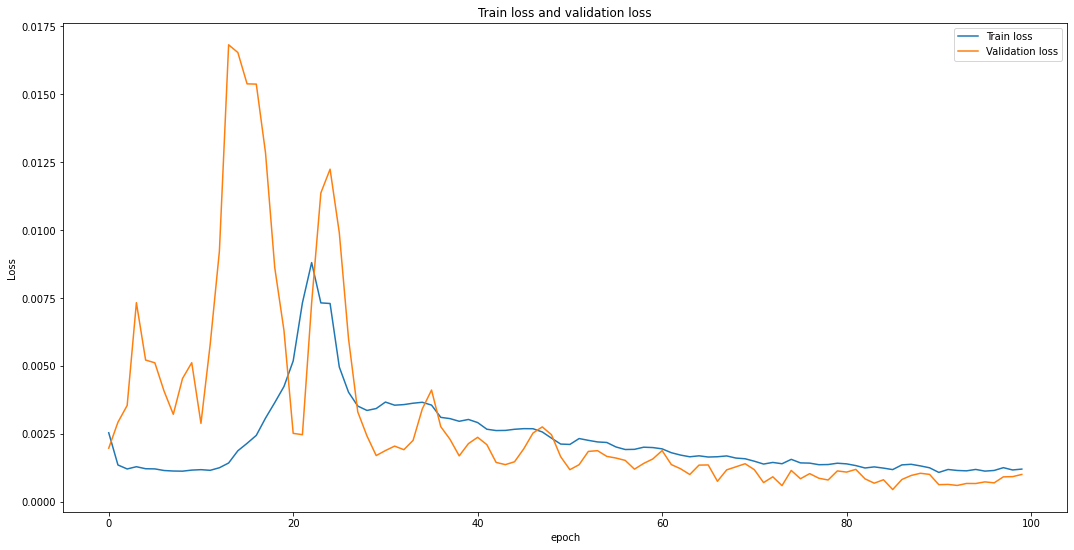

In [19]:
# Plot train loss and validation loss
def plot_loss(history):
    plt.figure(figsize = (18,9))
    plt.title('Train loss and validation loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_lstm)
# plot_loss(model_bilstm)
# plot_loss (history_gru)

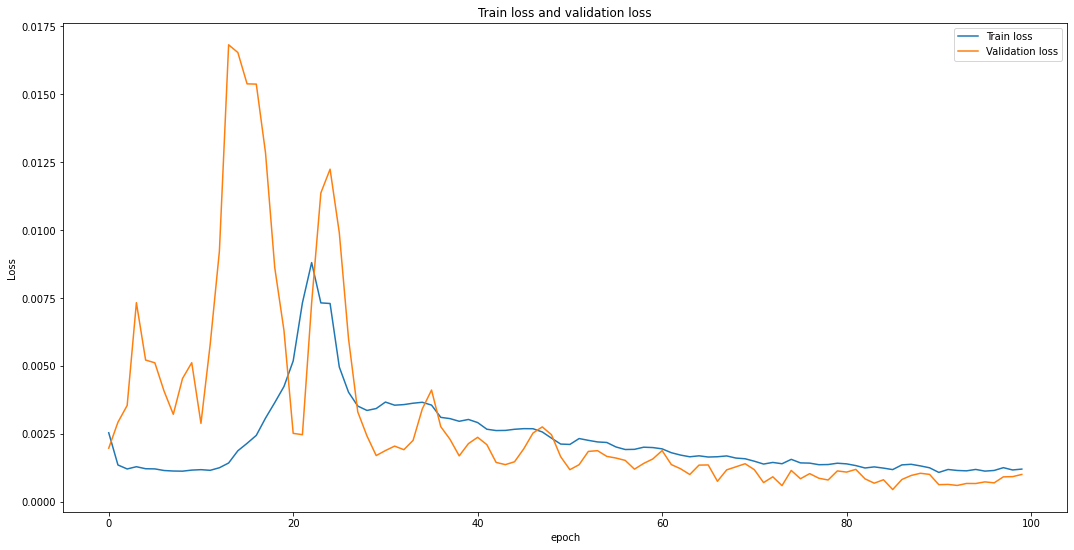

In [20]:
def plot_acc(history):  
  plt.figure(figsize = (18,9))
  plt.title('Training and Validation accuracy')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train acc', 'Validation acc'], loc='upper right')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

plot_loss(history_lstm)
# plot_loss (model_bilstm)
# plot_loss (history_gru)

In [21]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [25]:
def prediction(model):
    print(X_test)
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)
# prediction_bilstm = prediction(model_bilstm)
# prediction_gru = prediction(model_gru)

[[[0.581733   0.5844734  0.58273304]
  [0.5837445  0.58704966 0.5845313 ]
  [0.58648425 0.59245485 0.5891855 ]
  ...
  [0.6252198  0.6274908  0.6270893 ]
  [0.6182685  0.62411773 0.62050956]
  [0.6268414  0.6277642  0.62681127]]

 [[0.5837445  0.58704966 0.5845313 ]
  [0.58648425 0.59245485 0.5891855 ]
  [0.59135944 0.59444827 0.5944322 ]
  ...
  [0.6182685  0.62411773 0.62050956]
  [0.6268414  0.6277642  0.62681127]
  [0.6252998  0.6249429  0.6224169 ]]

 [[0.58648425 0.59245485 0.5891855 ]
  [0.59135944 0.59444827 0.5944322 ]
  [0.5966555  0.5966171  0.5928054 ]
  ...
  [0.6268414  0.6277642  0.62681127]
  [0.6252998  0.6249429  0.6224169 ]
  [0.6215014  0.6214667  0.62036926]]

 ...

 [[0.563433   0.5633606  0.5601768 ]
  [0.55029213 0.5495741  0.5394656 ]
  [0.5385922  0.5431039  0.5346529 ]
  ...
  [0.5768371  0.5797644  0.57711476]
  [0.5801708  0.5805871  0.57581544]
  [0.5806175  0.5842619  0.5786636 ]]

 [[0.55029213 0.5495741  0.5394656 ]
  [0.5385922  0.5431039  0.5346529 ]


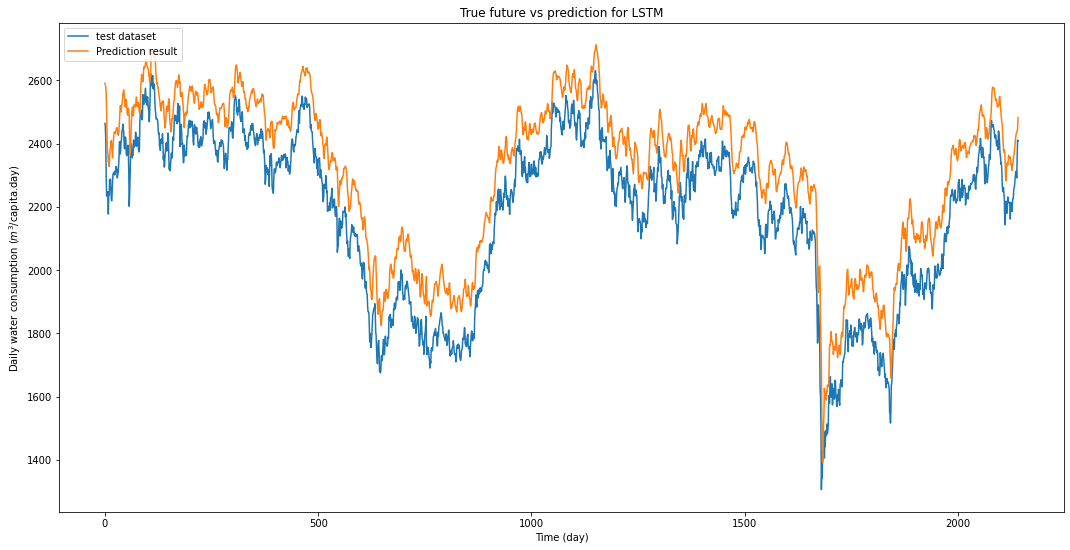

In [26]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(18, 9))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='test dataset')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction result')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(prediction_lstm, 'LSTM', y_test)
# plot_future(prediction_bilstm, 'bilstm', y_test)
# plot_future(prediction_lstm, 'GRU', y_test)

In [28]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(str(model_name) + ': ')
    # print('Mean Absolute Error: ' + str(errors))
    print('mse: ' + str(mse))
    print('rmse: ' + str(rmse))
    print('mae: ' + str(rmse))

evaluate_prediction(prediction_lstm, y_test, 'LSTM')
# evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
# evaluate_prediction(prediction_gru, y_test, 'GRU')



LSTM: 
mse: 18965.756
rmse: 137.71622
mae: 137.71622


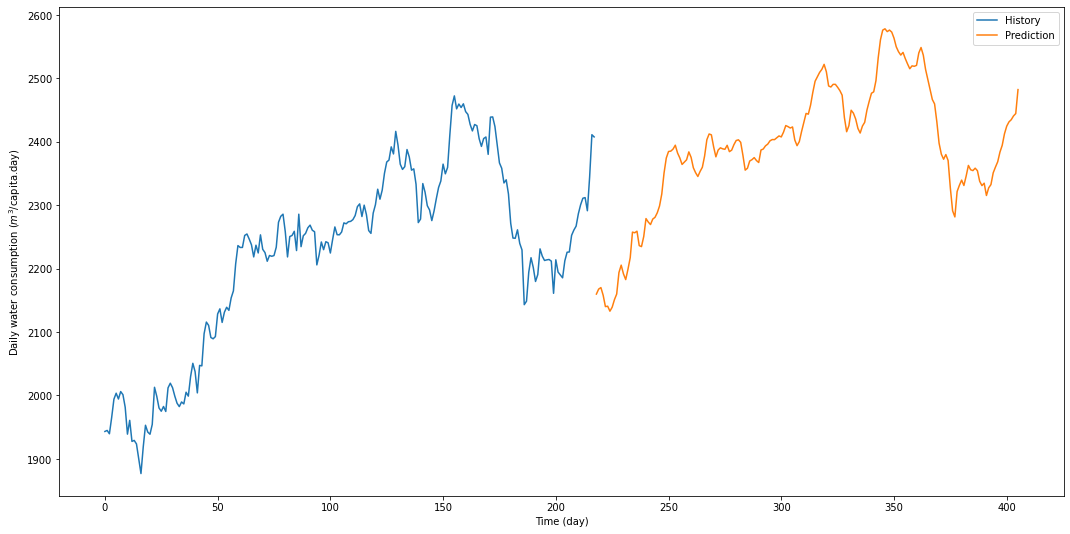

In [29]:
def plot_history_future(y_train, prediction):
    plt.figure(figsize=(18, 9))    
    range_history = len(y_train)
    upperRange = range_history + len(prediction)
    range_future = list(range(range_history,upperRange))
    plt.plot(np.arange(range_history), np.array(y_train), 
             label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')# Multi-step forecasting 
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the train set
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)   
    
    X_transformed = np.array(Xs)# Make prediction for unseen data using LSTM model
    prediction = model_lstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual

# print(test_dataset.shape)
# print(test_dataset)        
prediction = forecast(x_dataset, TIME_STEPS)

plot_history_future(y_dataset, prediction)